In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [17]:
torch.set_printoptions(3)

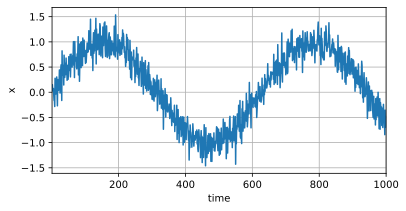

In [18]:
T=1000
time=torch.arange(1,T+1,dtype=torch.float32)
x=torch.sin(0.01*time)+torch.normal(0,0.2,(T,))  #(T,)表示一个一维元组
d2l.plot(time,x,'time','x',xlim=[1,1000],figsize=(6,3))

In [14]:
#用马尔可夫假设
tau=4
features=torch.zeros(T-tau,tau)
print(features.shape)
for i in range(tau):
    features[:,i]=x[i:T-tau+i]
labels=x[tau:].reshape(-1,1)
print(features.shape)
print(labels.shape)
batch_size,n_train=16,600
train_iter=d2l.load_array((features[:n_train],labels[:n_train]),batch_size,is_train=True)

torch.Size([996, 4])
torch.Size([996, 4])
torch.Size([996, 1])


In [19]:
def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def get_net():
    net=nn.Sequential(nn.Linear(4,10),nn.ReLU(),nn.Linear(10,1))
    net.apply(init_weights)
    return net
loss=nn.MSELoss()

In [20]:
def train(net,train_iter,loss,epochs,lr):
    trainer=torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l=loss(net(X),y)
            l.backward()
            trainer.step()
        print(f'epoch{epoch+1},',f'loss:{d2l.evaluate_loss(net,train_iter,loss)}')
net=get_net()
train(net,train_iter,loss,5,0.01)

epoch1, loss:0.052735526114702225
epoch2, loss:0.04939645117050723
epoch3, loss:0.046324394349204864
epoch4, loss:0.047778128597297166
epoch5, loss:0.04712133820315725


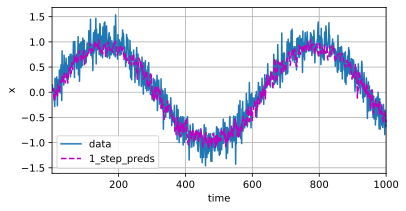

In [23]:
#模型预测下一个时间步
onestep_preds=net(features)
d2l.plot([time,time[tau:]],[x.detach().numpy(),onestep_preds.detach().numpy()],'time'
       ,'x',legend=['data','1_step_preds'],xlim=[1,1000],figsize=(6,3))

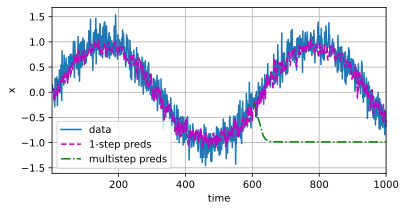

In [24]:
# 初始化多步预测结果的张量
multistep_preds = torch.zeros(T)
# 将已知的真实数据赋值给多步预测结果
multistep_preds[:n_train + tau] = x[:n_train + tau]
# 对剩余时间步进行多步预测
for i in range(n_train + tau, T):
    # 获得多步预测结果
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1,-1)))

# 进行数据可视化
d2l.plot(
    [time, time[tau:], time[n_train + tau:]], 
    [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()],        
    'time', 
    'x', 
    legend = ['data', '1-step preds', 'multistep preds'], 
    xlim=[1,1000],
    figsize=(6,3) )  

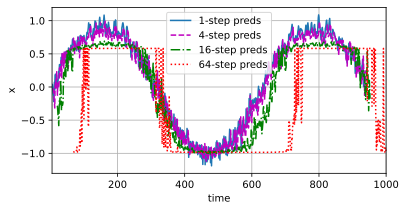

In [25]:
# 最大步长
max_steps = 64
# 初始化特征张量
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 从 0 到 tau-1进行遍历
for i in range(tau):
    # 构造特征矩阵
    features[:, i] = x[i:i + T - tau - max_steps + 1]
    
# 从 tau 到 tau + max_steps - 1，通过 net(features[:, i - tau:i]) 进行多步预测
for i in range(tau, tau + max_steps):
    # 进行多步预测并更新特征矩阵
    features[:,i] = net(features[:, i - tau:i]).reshape(-1)
    
# 预测的步长
steps = (1, 4, 16, 64)
# 进行数据可视化
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
        [features[:, (tau + i - 1)].detach().numpy() for i in steps],
        'time',
        'x',
        legend = [f'{i}-step preds' for i in steps],
        xlim = [5,1000],
        figsize=(6,3) )